<a href="https://colab.research.google.com/github/AbdelRayan/SleepSlopeProject/blob/main/zeynep__trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fooof


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 2.2 MB/s eta 0:00:00


In [2]:
!pip install neurodsp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 2.4 MB/s eta 0:00:00


In [3]:
!pip install drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: httplib2
    Found existing installation: httplib2 0.22.0
    Uninstalling httplib2-0.22.0:
      Successfully uninstalled httplib2-0.22.0


In [4]:
!pip install google.colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


In [5]:
# Fooof
from fooof import FOOOF
from fooof.sim.gen import gen_power_spectrum
from fooof.sim.gen import gen_aperiodic
from fooof.sim.utils import set_random_seed
from fooof.plts.spectra import plot_spectra
from fooof.plts.annotate import plot_annotated_model
from fooof.plts.annotate import plot_annotated_peak_search

# Import a utility to download and load example data
from fooof.utils.download import load_fooof_data
import matplotlib.pyplot as plt

#NeuroDSP
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.spectral import compute_spectrum, rotate_powerlaw
from neurodsp.utils.download import load_ndsp_data
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series

#scipy.io
from scipy.io import loadmat
import numpy as np
from scipy import signal
from scipy.signal import savgol_filter
from scipy.stats import zscore
import matplotlib.pyplot as plt



<ipython-input-5-80e6ba1eb26f>:2: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [6]:
#download mat file from drive
#google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Load Matlab File
data = loadmat('/content/drive/My Drive/SleepCyc/HPC_100_CH18_0.continuous.mat')
# Extract 'HPC' Variable from Loaded Matlab File
hpc_d= data['HPC']
# Print the number of Points in 'HPC' Variable
print("number of points",len(hpc_d))

number of points 27009195


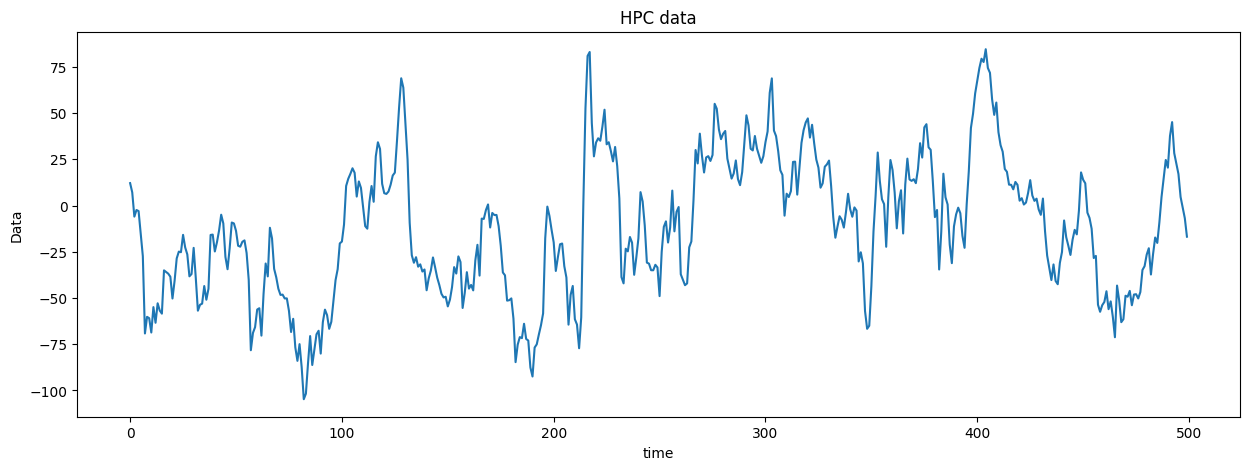

In [8]:
# plot data
plt.figure(figsize=(15, 5))
# x-axis in time untill 500
range = np.arange(0, 500)

# y-axis in data untill 500
plt.plot(range, hpc_d[0:500])
plt.title('HPC data')
plt.xlabel('time')
plt.ylabel('Data')
plt.show()


In [9]:
# Normalization of Data
def normalizer(y):
  return (y-np.nanmean(y))/(np.nanstd(y))

norm_hpc = normalizer(np.array(hpc_d))



In [10]:
#Flattening
norm_hpc = np.ravel(norm_hpc)
# Sampling frequency is 2500
fs = 2500
time = np.arange(0, len(norm_hpc)/fs, 1/fs)


In [11]:
# Determine Number of Samples per Segment
nperseg = min(2500, len(norm_hpc))
#Extracting Power Spectrum for the first 3-sec of data
freq, psd = compute_spectrum(norm_hpc[:7500], fs, method='welch', nperseg=nperseg)



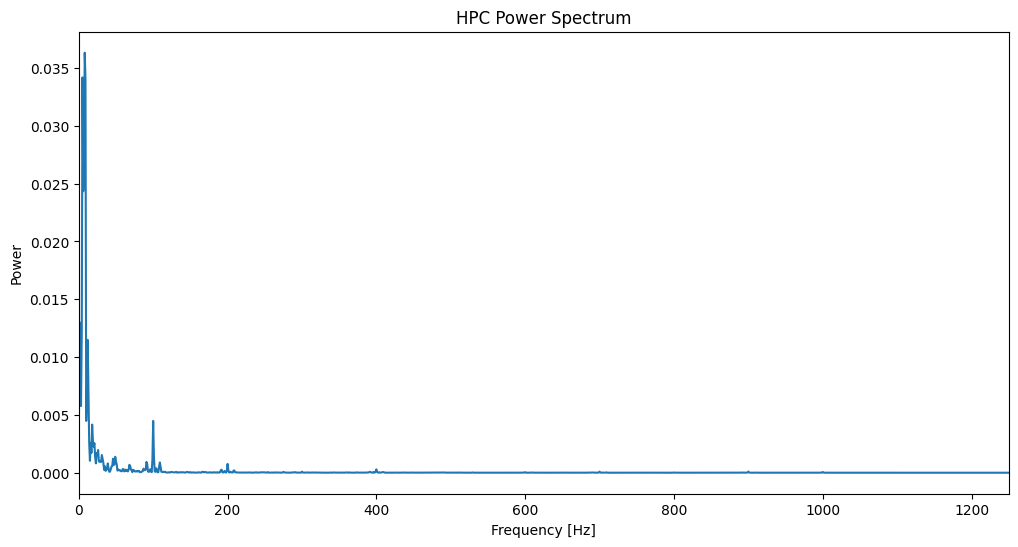

In [12]:
# Plotting Power spectrum
plt.figure(figsize=(12, 6))
# freq = frequencies & psd = power values
plt.plot(freq, psd)
plt.title('HPC Power Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
# Set x-axis limits - it ranged from 0 to half of the sampling frequency
plt.xlim(0, fs/2)
plt.show()


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 1.00
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.



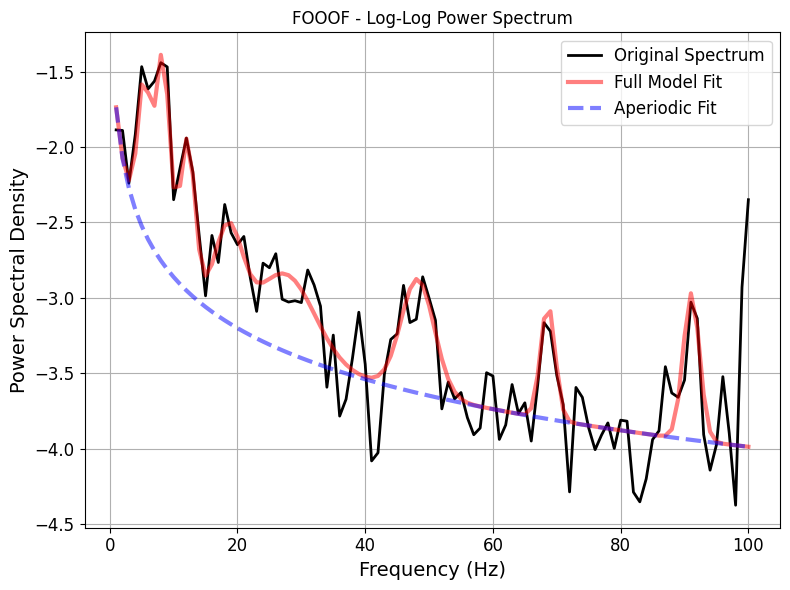

In [13]:
# Initialize and train FOOOF model on extracted PSD data
# FOOOF class is created and stored in variable "fm"
fm = FOOOF()
# freq = frequency data & psd = power spectral density data
# fit = fit the model to input data
fm.fit(freq, psd, freq_range=[1, 100])
 # freq_range can vary

# Plotting the FOOOF power spectrum
fig, ax = plt.subplots(figsize=(8, 6))
fm.plot(ax=ax)
plt.ylabel('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.title('FOOOF - Log-Log Power Spectrum')
plt.show()


In [14]:
# norm_hpc_60_min contains first 45 mins of the data (if 30 mins the 30*60*fs)
norm_hpc_45_min = norm_hpc[:45*60*fs]
# window length is set to duration of 3 seconds
window_length = 3 * fs
# Empty list is initialized to store aperiodic parameters calculated from each window.
ap_param_HPC = []
# freq_range specifies the frequency range for FOOOF analysis
freq_range = [1,100]


In [ ]:
for start in np.arange(0, len(norm_hpc_45_min) - window_length + 1, window_length):
    window = norm_hpc_45_min[start:start + window_length]
    window = np.ravel(window)
    freq, psd = compute_spectrum(window, fs, method='welch', avg_type='mean', nperseg=window_length)
    fm = FOOOF()
    fm.fit(freq, psd, freq_range)
    ap_param_HPC.append(fm.get_params('aperiodic_params'))


In [ ]:
slopes_H = [param[0] for param in ap_param_HPC]
time = np.arange(1.5, 1.5 + 3 * len(ap_param_HPC), 3)
time_minutes = time / 60

plt.figure(figsize=(10, 6))
plt.plot(time_minutes, slopes_H, marker='o', linestyle='-', color ='black')
plt.title("Slope of Aperiodic Signal Component Over Time")
plt.xlabel("Time (mins)")
plt.ylabel("Slope")
plt.show()
